In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import shutil
import matplotlib.pyplot as plt
import re
import traceback
%matplotlib inline

In [2]:
# focus on three regions now
regions = [
    "Oberösterreich",
    "Salzburg",
    "Steiermark"
]
region_dirs = ["/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_{}_gw_{}".format(num, regions[idx]) for idx, num in enumerate(range(4, 6 + 1))]
region_dirs

['/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_4_gw_Oberösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_6_gw_Steiermark']

## Measuring point data with regions

In [3]:
def get_num_from_str(string):
    matches = re.findall(r"\d+\.\d+", string)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_mp_attrs(region, region_dir, mp_num):

    mp_base_data_path = path.join(region_dir, "Stammdaten", "Stammdaten-{0}.txt".format(mp_num))
    
    land_height = np.nan
    mp_height = np.nan
    bottom_line = np.nan
    t_measuring_depth = np.nan
    
    with open(mp_base_data_path, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if "Geländehöhe" in line:
                land_height = get_num_from_str(line)
                
            elif "Messpunkthöhe" in line:
                mp_height = get_num_from_str(line)
                
            elif "Sohllage" in line:
                bottom_line = get_num_from_str(line)
                
            elif "T-Messtiefe u.GOK" in line:
                t_measuring_depth = get_num_from_str(line)
                
                break # since it's always listed latest in the file
    
    mp = {
        "land_height": land_height,
        "mp_height": mp_height,
        "bottom_line": bottom_line,
        "t_measuring_depth": t_measuring_depth
    }
    
    return mp


# test
region_idx = 0

# try mp with full attr
mp_num = 307843 
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

# try mp with missing attr -> np.nan in missed value
mp_num = 306910
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

mp 307843 attrs: {'land_height': '275.71', 'mp_height': '276.71', 'bottom_line': '265.81', 't_measuring_depth': '9.70'}
mp 306910 attrs: {'land_height': '257.75', 'mp_height': '258.75', 'bottom_line': '253.26', 't_measuring_depth': nan}


In [4]:
values = []

for i in range(len(regions)):
    region = regions[i]
    region_dir = region_dirs[i]
    # mps: measurment points 
    df_mps_path = path.join(region_dir, "messstellen_alle.csv")
    df_mps = pd.read_csv(df_mps_path, sep=";")
    # filter to typ == 'gw' then del typ col
    df_mps = df_mps.query("typ=='gw'")
    del df_mps["typ"]
    
    df_mps["region"] = region
    
    # for every mp in the region get attributes
    # create attrs cols and init with np.nan
    mp_attrs = ["land_height", "mp_height", "bottom_line", "t_measuring_depth"]
    for mp_attr in mp_attrs:
        df_mps[mp_attr] = np.nan
    
    # fill with values when available
    for index, row in df_mps.iterrows():
        mp_num = row["hzbnr01"]
        mp_attr_vals = get_mp_attrs(region, region_dir, mp_num = mp_num)
        for mp_attr in mp_attrs:
            df_mps.at[index, mp_attr] = float(mp_attr_vals[mp_attr])
    
    values.extend(df_mps.values.tolist())

colnames = ["x", "y", "dbmsnr", "hzbnr01", "region"] + mp_attrs
df_mps_all = pd.DataFrame(values, columns = colnames)
df_mps_all["x"] = df_mps_all["x"].str.replace(",", ".").astype(float)
df_mps_all["y"] = df_mps_all["y"].str.replace(",", ".").astype(float)

df_mps_all

,x,y,dbmsnr,hzbnr01,region,land_height,mp_height,bottom_line,t_measuring_depth
0,375733.35,480950.72,4003250,344614,Oberösterreich,358.98,359.88,347.69,11.10
1,453010.07,473646.18,4002979,376376,Oberösterreich,310.49,310.79,296.61,NaN
2,436515.22,454178.87,4003213,344416,Oberösterreich,439.25,439.02,374.02,50.23
3,379427.33,484160.43,4002834,374074,Oberösterreich,352.39,353.09,349.51,2.78
4,506520.73,476655.34,4002230,308874,Oberösterreich,232.29,233.49,223.98,NaN
...,...,...,...,...,...,...,...,...,...
1707,597722.62,316229.92,6002179,311696,Steiermark,217.57,217.77,212.77,4.70
1708,555754.86,318845.33,6003571,356576,Steiermark,296.86,297.66,288.86,7.20
1709,596263.48,318031.55,6002809,340018,Steiermark,220.91,220.84,216.19,4.37
1710,486915.25,376334.05,6003594,356790,Steiermark,913.86,914.76,901.76,9.10


In [5]:
sub_path = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/processed/gw_test_empty.csv"
submission_df = pd.read_csv(sub_path)
test_ids = submission_df.columns[1:]

In [6]:
test_ids

Index(['324095', '323295', '323154', '304535', '326934', '307397', '319053',
       '303727', '319699', '304352',
       ...
       '345629', '345710', '345744', '345736', '345694', '345728', '345645',
       '345652', '345678', '345686'],
      dtype='object', length=487)

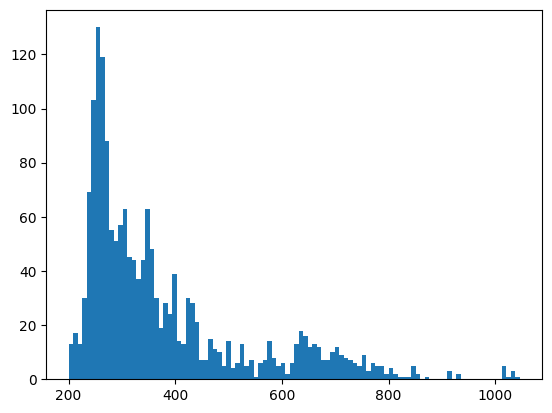

In [10]:
plt.hist(df_mps_all["land_height"], bins=100);

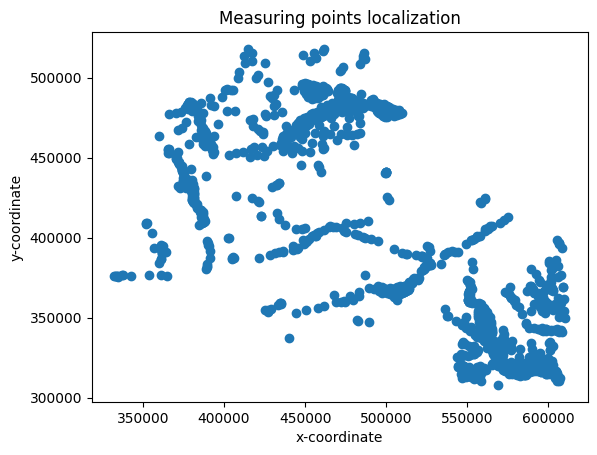

In [17]:
plt.scatter(df_mps_all["x"], df_mps_all["y"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Measuring points localization")
plt.show()

## Process region directory data

In [7]:
# know how many rows to skip in pd.read_csv
def csv_find_skiprows(filepath, lookup):
    skiprows = 0
    # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
    with open(filepath, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if lookup in line:
                skiprows = num
                # print("skiprows:", skiprows)
                break
                
    return skiprows

def process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=False):
    
    folder_dir = path.join(region_dir, folder_name)
    
    print("> Processing {} - {}..".format(region, folder_name))
    
    # clean previous processing output
    output_dir = path.join(folder_dir, "processed_data")
    
    try:
        shutil.rmtree(output_dir)
    except:
        pass
    os.mkdir(output_dir)
    
    filenames = os.listdir(folder_dir)
    for filename in filenames:
        
        filepath = path.join(folder_dir, filename)
        
        # process only files (don't iterate over output dir)
        if not path.isfile(filepath):
            continue
        
        # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
        lookup = "Werte:"
        skiprows = csv_find_skiprows(filepath, lookup)
        
        # load and process .csv file
     
        df = pd.read_csv(filepath, sep=" ;", header=None, skiprows=skiprows,
                               encoding='unicode_escape')
        
        

        # manipulate data splitting values into more possible regressors (e.g. date -> day, month, year)
        df.columns = ["date & time", val_col_name, "empty"]
        del df["empty"]
        
        # remove rows with gaps ("Lücke")
        df = df[~df[val_col_name].str.contains("Lücke")]
        
        # clean data from white spaces
        df["date & time"] = df["date & time"].str.replace("  ", "")
        
        df[["date", "time"]] = df["date & time"].str.split(" ", expand=True)
        df[["day", "month", "year"]] = df["date"].str.split(".", expand=True)
        df[["hour", "minute", "second"]] = df["time"].str.split(":", expand=True)
        # clean gw-level value and convert it to float
        df[val_col_name] = df.apply(
            lambda row: float(row[val_col_name].split(" ;")[0].replace(",", "."))
            , axis=1
        )
        # rearrange cols
        df = df[["date", "day", "month", "year", "time", "hour", "minute", "second", val_col_name]]
        
        df.to_csv(path.join(output_dir, "processed_{0}".format(filename)), index=False)
        
        # if debugging, process only one file from each sub dir 
        if debugging:
            break
        
    print("\t- Done!")

    return None

In [8]:
# Define a function to map month to season for exogenous varibles
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:  # months 12, 1, 2
        return 'Winter'

In [39]:
def create_region_mps_summary(region, region_dir, df_mps, test_ids, debugging):
    
    summary_dir  = path.join(region_dir, "Summary")
    test_dir = path.join(region_dir, "test-data")
    
    print("> Creating {0} Summary..".format(region))
    
    # clean previous processing output   
    try:
        shutil.rmtree(summary_dir)
        shutil.rmtree(test_dir)
    except:
        pass
    os.mkdir(summary_dir)
    os.mkdir(test_dir)
    
    try:
        # get processed monthly water level files as starting point
        prc_mnth_lvls_dir = path.join(region_dir, "Grundwasserstand-Monatsmittel", "processed_data")
        mnth_lvls_filenames = os.listdir(prc_mnth_lvls_dir)
        mp_num_dict = df_mps["hzbnr01"].to_dict()
        reverse_dict = {v: k for k, v in mp_num_dict.items()}
        
        
        for mnth_lvls_filename in mnth_lvls_filenames:
            
            mp_num = mnth_lvls_filename.split(".")[0].split("-")[-1]
            
            if debugging:
                mp_num = 305540 # override mp_num value to choose a mp that we have temperature data for
                print("mp_num:", mp_num)
                
            df = pd.read_csv(path.join(prc_mnth_lvls_dir, mnth_lvls_filename), sep=",")

            # add few features from measuring point dataframe: x & y coordinates and land height
            num = int(mp_num)
            df["x"] = df_mps.loc[reverse_dict[num]]["x"] if num in reverse_dict else np.nan
            df["y"] = df_mps.loc[reverse_dict[num]]["y"] if num in reverse_dict else np.nan
            df["land_height"] = df_mps.loc[reverse_dict[num]]["land_height"] if num in reverse_dict else np.nan
            
            # add extra fields, init them as NaN, then try to fill them with values
            # add fields: yr_max, yr_max_dist, yr_max_abs(dist)
            df["yr_max"] = np.nan
            df["yr_max_dist"] = np.nan
            df["yr_max_abs(dist)"] = np.nan
            
            yr_max_fpath = path.join(region_dir, "Grundwasserstand-Jahresmaxima", "processed_data", "processed_Grundwasserstand-Jahresmaxima-{0}.csv".format(mp_num))
            
            if path.exists(yr_max_fpath):
                
                df_yr_max = pd.read_csv(yr_max_fpath, sep=",")[["year", "gw-level"]]
                df_yr_max.drop_duplicates(subset=["year"], keep='first', inplace=True)
                
                # set yr as index and create dict for O(1) search
                df_yr_max.set_index("year", inplace=True)
                dct_yr_max = df_yr_max.to_dict("index")
                
                df["yr_max"] = df.apply(
                    lambda row: dct_yr_max[row["year"]]["gw-level"] if row["year"] in dct_yr_max else np.nan, axis=1)
                yr_max_mean = df["yr_max"].mean()
                df["yr_max"].fillna(round(yr_max_mean, 2), inplace=True)
                df["yr_max_dist"] = df.apply(lambda row: round(row["gw-level"] - row["yr_max"], 2), axis=1)
                # df["yr_max_dist"] = df.apply(
                #     lambda row: round(row["gw-level"] - row["yr_max"], 2) if not row["yr_max"] == np.nan else np.nan
                #     , axis=1)
                df["yr_max_abs(dist)"] = df["yr_max_dist"].abs().round(2)
            
                
                # free resources
                del df_yr_max
                del dct_yr_max
                
            # add fields: yr_min, yr_min_dist, yr_min_abs(dist)
            df["yr_min"] = np.nan
            df["yr_min_dist"] = np.nan
            df["yr_min_abs(dist)"] = np.nan
            
            yr_min_fpath = path.join(region_dir, "Grundwasserstand-Jahresminima", "processed_data", "processed_Grundwasserstand-Jahresminima-{0}.csv".format(mp_num))
            
            if path.exists(yr_min_fpath):
                
                df_yr_min = pd.read_csv(yr_min_fpath, sep=",")[["year", "gw-level"]]
                df_yr_min.drop_duplicates(subset=["year"], keep='first', inplace=True)
                
                # set yr as index and create dict for O(1) search
                df_yr_min.set_index("year", inplace=True)
                dct_yr_min = df_yr_min.to_dict("index")
                
                df["yr_min"] = df.apply(
                    lambda row: dct_yr_min[row["year"]]["gw-level"] if row["year"] in dct_yr_min else np.nan
                    , axis=1)
                yr_min_mean = df["yr_min"].mean()
                df["yr_min"].fillna(round(yr_min_mean, 2), inplace=True)
                df["yr_min_dist"] = df.apply(lambda row: round(row["gw-level"] - row["yr_min"], 2), axis=1)
                # df["yr_min_dist"] = df.apply(
                #     lambda row: round(row["gw-level"] - row["yr_min"], 2) if not row["yr_min"] == np.nan else np.nan
                #     , axis=1)
                df["yr_min_abs(dist)"] = df["yr_min_dist"].abs().round(2)
                
                # free resources
                del df_yr_min
                del dct_yr_min
                
            # add field: temp to add temperature (Celcius) to every monthly measurement if available   
            df["temp"] = np.nan
            
            mnth_temp_fpath = path.join(region_dir, "Grundwassertemperatur-Monatsmittel", "processed_data", "processed_Grundwassertemperatur-Monatsmittel-{0}.csv".format(mp_num))
            
            # not all mps have monthly temperature data, in this case we keep it as np.nan            
            if path.exists(mnth_temp_fpath):

                # time in both ds is 00:00:00, so I only care about the date
                df_mnth_temp = pd.read_csv(mnth_temp_fpath, sep=",")[["date", "temp"]]
                df_mnth_temp.set_index("date", inplace=True)
                
                df["temp"] = df.apply(
                    lambda row: df_mnth_temp.loc[row["date"]]["temp"] if row["date"] in df_mnth_temp.index else np.nan
                    , axis=1)
                
                # free resources
                del df_mnth_temp
            
            
            
            # convert the date field to datatime object and add quarter and season to the dataframe
            df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
            df["quarter"] = df["date"].dt.quarter
            df["season"] = df["date"].dt.month.apply(get_season)
            
            # drop ["time", "hour", "minute", "second"] cols since time is always 00:00:00
            del df["time"]
            del df["hour"]
            del df["minute"]
            del df["second"]
            del df["day"]
            del df["yr_max_dist"]
            del df["yr_min_dist"]
            
            if debugging:
                print(df)
            
            # save summary df
            df_summary_path = path.join(summary_dir, "Summary-{0}.csv".format(mp_num))
            test_path = path.join(test_dir, "test-{}.csv".format(mp_num))
            
            if mp_num in test_ids:
                #save to test directory
                df.to_csv(test_path, sep=",", index = False)
            else:
                # save to the summary directory for model training
                df.to_csv(df_summary_path, sep=",", index = False)            
                
            # free resources
            del df
            
            # if debugging, create summary file for only one mp 
            if debugging:
                break
            
        
    except Exception as ex:
        print("[Error]")
        print(traceback.format_exc())
        
    print("\t- Done!")
    
    return None

def process_region_files(region, region_dir, df_mps, test_ids):
    
    # process and manipulate region files into clean .csv files
    FILE_PROCESSING_DEBUGGING = False # False => process  all files     
    folder_names = [
        "Grundwasserstand-Jahresmaxima",
        "Grundwasserstand-Jahresminima",
        "Grundwasserstand-Monatsmittel",
        "Grundwassertemperatur-Monatsmittel"        
    ]
    
    for folder_name in folder_names:
        if not folder_name == "Grundwassertemperatur-Monatsmittel":
            val_col_name = "gw-level"
        else:
            val_col_name = "temp"
            
        # process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=FILE_PROCESSING_DEBUGGING)
        
    # create summary files on monthly base
    SUMMARY_Creating_DEBUGGING = False # False => create summary for all mps in region
    create_region_mps_summary(region, region_dir, df_mps, test_ids, debugging=SUMMARY_Creating_DEBUGGING)

In [43]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    region_idx = 2
    region = regions[region_idx]
    region_dir = region_dirs[region_idx]
    process_region_files(region, region_dir, df_mps_all, test_ids)

> Creating Steiermark Summary..
	- Done!


## Data Preprocess and Addition of Exogenous Variables

In [44]:
import pandas as pd
from darts import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [45]:
summary_dir = path.join(region_dir, "summary")
filenames = os.listdir(summary_dir)
total_df = []

for filename in filenames:
    filepath = path.join(summary_dir, filename)
    df = pd.read_csv(filepath)
    total_df.append(df)

In [46]:
merge_df = pd.concat(total_df)
merge_df = merge_df.sort_values("date")
merge_df

,date,month,year,gw-level,x,y,land_height,yr_max,yr_max_abs(dist),yr_min,yr_min_abs(dist),temp,quarter,season
0,1948-03-01,3,1948,343.29,559872.74,354528.88,351.00,344.10,0.81,342.81,0.48,NaN,1,Spring
0,1948-03-01,3,1948,328.17,560795.32,347618.82,334.56,329.03,0.86,327.79,0.38,NaN,1,Spring
1,1948-04-01,4,1948,328.27,560795.32,347618.82,334.56,329.03,0.76,327.79,0.48,NaN,2,Spring
0,1948-04-01,4,1948,343.40,559283.28,355002.35,350.95,344.54,1.14,342.75,0.65,NaN,2,Spring
0,1948-04-01,4,1948,345.80,559074.14,355315.40,351.67,345.05,0.75,343.91,1.89,NaN,2,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2021-12-01,12,2021,711.23,499966.50,367619.20,737.99,711.99,0.76,711.20,0.03,NaN,4,Winter
213,2021-12-01,12,2021,698.37,506601.41,360701.12,706.94,700.93,2.56,698.21,0.16,NaN,4,Winter
483,2021-12-01,12,2021,224.93,591105.26,317843.69,227.26,225.61,0.68,224.28,0.65,12.6,4,Winter
647,2021-12-01,12,2021,631.10,512591.43,368320.69,641.18,632.79,1.69,631.02,0.08,NaN,4,Winter


In [52]:
merge_df["temp"] = merge_df["temp"].interpolate(method="linear")
merge_df

,date,month,year,gw-level,x,y,land_height,yr_max,yr_max_abs(dist),yr_min,yr_min_abs(dist),temp,quarter,season
0,1948-03-01,3,1948,343.29,559872.74,354528.88,351.00,344.10,0.81,342.81,0.48,NaN,1,Spring
0,1948-03-01,3,1948,328.17,560795.32,347618.82,334.56,329.03,0.86,327.79,0.38,NaN,1,Spring
1,1948-04-01,4,1948,328.27,560795.32,347618.82,334.56,329.03,0.76,327.79,0.48,NaN,2,Spring
0,1948-04-01,4,1948,343.40,559283.28,355002.35,350.95,344.54,1.14,342.75,0.65,NaN,2,Spring
0,1948-04-01,4,1948,345.80,559074.14,355315.40,351.67,345.05,0.75,343.91,1.89,NaN,2,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2021-12-01,12,2021,711.23,499966.50,367619.20,737.99,711.99,0.76,711.20,0.03,9.866667,4,Winter
213,2021-12-01,12,2021,698.37,506601.41,360701.12,706.94,700.93,2.56,698.21,0.16,11.233333,4,Winter
483,2021-12-01,12,2021,224.93,591105.26,317843.69,227.26,225.61,0.68,224.28,0.65,12.600000,4,Winter
647,2021-12-01,12,2021,631.10,512591.43,368320.69,641.18,632.79,1.69,631.02,0.08,11.750000,4,Winter


In [ ]:
def cyclical_encoding(data, cycle_length):
""" function to capture pattern on calender features """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

In [55]:
def create_exogenous_variables(region_dir):
    
    summary_dir = path.join(region_dir, "Summary")

    filenames = os.listdir(summary_dir)

    df_list = []
    for filename in filenames:
        
        filepath = path.join(summary_dir, filename)
        
        df = read.read_csv(filepath)
        df_list.append(df)
        
    # merge all the dataframe
    all_df = pd.concat(df_list)

    # temperature feature
    temp_features = all_df["temp"].copy()
    temp_features["temp_rolling_mean_1_year"] = temp_features['temp'].rolling(12, closed='left').mean()
    temp_features["temp_rolling_max_1_year"] = temp_features['temp'].rolling(12, closed='left').max()

    del temp_features["temp"]

    # abs_yr_max feature
    yr_max_features = all_df["yr_max_abs(dist)"].copy
    yr_max_features["yma_rolling_mean_1_year"] = yr_max_features["yr_max_abs(dist)"].rolling(12, closed="left").mean()
    yr_max_features["yma_rolling_max_1_year"] = yr_max_features["yr_max_abs(dist)"].rolling(12, closed="left").max()
    yr_max_features["yma_rolling_mean_2_year"] = yr_max_features["yr_max_abs(dist)"].rolling(12*2, closed="left").mean()
    yr_max_features["yma_rolling_max_2_year"] = yr_max_features["yr_max_abs(dist)"].rolling(12, closed="left").max()

    del yr_max_features["yr_max_abs(dist)"]

    # abs_yr_max feature
    yr_min_features = df["yr_min_abs(dist)"].copy
    yr_min_features["ymi_rolling_mean_1_year"] = yr_min_features["yr_min_abs(dist)"].rolling(12, closed="left").mean()
    yr_min_features["ymi_rolling_max_1_year"] = yr_min_features["yr_min_abs(dist)"].rolling(12, closed="left").max()
    yr_min_features["ymi_rolling_mean_2_year"] = yr_min_featuress["yr_min_abs(dist)"].rolling(12*2, closed="left").mean()
    yr_min_features["ymi_rolling_max_2_year"] = yr_min_features["yr_min_abs(dist)"].rolling(12, closed="left").max()

    # cyclic calender and seasonal features
    month_cyclic = cyclical_encoded(all_df["month"], cycle_length=24)
    quarter_cyclic = cyclical_encoded(all_df["quarter"], cycle_length=4)

    # categorical features
    # encoder = LabelEncoder
    # all_df["season"] = all_df["season"].astype("category")
    # all_df.loc[:,"season"] = all_df.loc[:, "season"].apply(encoder.fit_tranform)
    
    # merge the exogenous features to the main data
    df_exogenous_features = pd.concat([all_df, temp_features, yr_max_features, yr_min_features], axis=1)


    # add intereaction between exogenous varibles
    transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
    ).set_output(transform="pandas")

    # pick columns for exgennous varibles for intereactions
    copy_df = all_df.copy
    copy_df.drop("season", axis=1)
    poly_cols = copy_df.columns[7:].tolist()

    poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols].dropna())
    poly_features = poly_features.drop(columns=poly_cols)
    poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
    poly_features.columns = poly_features.columns.str.replace(" ", "_")
    df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)

    return df_exogenous_features    

In [9]:
series_df = pd.read_csv("../../ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg/Summary/Summary-319889.csv")
series_df1 = pd.read_csv("../../ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg/Summary/Summary-320846.csv")
merged_df = pd.concat([series_df, series_df1])
merged_df.sort_values(by=["date"])
merged_df

,date,month,year,gw-level,x,y,land_height,yr_max,yr_max_abs(dist),yr_min,yr_min_abs(dist),temp
0,1976-01-01,1,1976,460.07,385847.58,412673.77,465.39,460.91,0.84,459.80,0.27,NaN
1,1976-02-01,2,1976,459.96,385847.58,412673.77,465.39,460.91,0.95,459.80,0.16,NaN
2,1976-03-01,3,1976,459.95,385847.58,412673.77,465.39,460.91,0.96,459.80,0.15,NaN
3,1976-04-01,4,1976,460.24,385847.58,412673.77,465.39,460.91,0.67,459.80,0.44,NaN
4,1976-05-01,5,1976,460.59,385847.58,412673.77,465.39,460.91,0.32,459.80,0.79,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
325,2021-08-01,8,2021,434.06,380258.02,425245.05,439.38,434.89,0.83,433.63,0.43,10.6
326,2021-09-01,9,2021,434.09,380258.02,425245.05,439.38,434.89,0.80,433.63,0.46,11.1
327,2021-10-01,10,2021,433.80,380258.02,425245.05,439.38,434.89,1.09,433.63,0.17,11.5
328,2021-11-01,11,2021,433.69,380258.02,425245.05,439.38,434.89,1.20,433.63,0.06,11.4


In [13]:
freq = "ME"
y_all = TimeSeries.from_group_dataframe(merged_df,
                                       group_cols=["x","y","land_height"],
                                       time_col="date",
                                       value_cols=["gw-level"],
                                       freq=freq)

feature_cov_all = TimeSeries.from_group_datafrom(merged_df,
                                                group_cols=["x","y","land_height"],
                                                time_col="date",
                                                value_cols=["month","year","yr_max_abs(dist)","yr_min_abs(dist)","temp"],
                                                freq=freq)


y_train_all = y_all[:-24]

# y_all = TimeSeries.from_series(series_df["gw-level"])
# features = ["month","year","yr_max_abs(dist)","yr_min_abs(dist)"]
# future_cov = TimeSeries.from_dataframe(series_df[features])
# y_train = y_all[:-24]

model = RegressionModel(lags=[-1,-2,-12],
                       lags_future_covariates={
        'yr_max_abs(dist)': [0, -1, -2], # Lags for yr_min_abs(dist)
        'default_lags': [0]  # Default lags for all other future covariates
    },
                       model=LinearRegression())

model.fit(y_train_all, future_covariates=future_cov_all)

ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='ME'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases


ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='ME'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [10]:
pred= model.predict(n=24,
                   series=y_train,
                   future_covariates=future_cov)

<Axes: xlabel='time'>

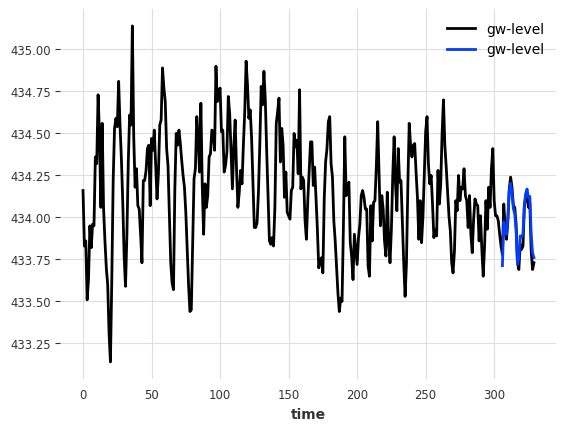

In [16]:
y_all.plot()
pred.plot()

In [13]:
from darts.metrics import mape

# Calculate MAPE
mape_value = mape(y_all[-24:], pred)

print(f"MAPE: {mape_value:.2f}%")

MAPE: 0.01%


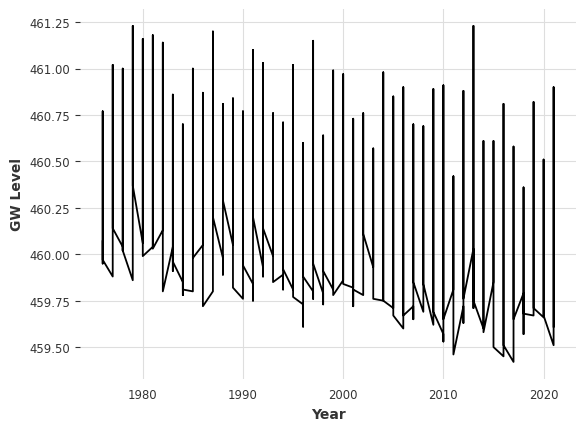

In [14]:
df = series_df.copy()
df = df.set_index("year")

# Plot using pandas plot function
df.plot(y="gw-level", xlabel="Year", ylabel="GW Level", legend=False)
plt.show()

In [16]:
y = TimeSeries.from_series(series_df["gw-level"])

In [17]:
y_train = y[:-24]

<TimeSeries (DataArray) (time: 527, component: 1, sample: 1)>
array([[[460.07]],

       [[459.96]],

       [[459.95]],

       [[460.24]],

       [[460.59]],

       [[460.77]],

       [[460.54]],

       [[460.66]],

       [[460.61]],

       [[460.16]],

...

       [[460.28]],

       [[460.27]],

       [[460.51]],

       [[460.82]],

       [[460.31]],

       [[460.14]],

       [[460.  ]],

       [[459.79]],

       [[459.85]],

       [[459.71]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 519 520 521 522 523 524 525 526
  * component  (component) object 'gw-level'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None